In [1]:
import numpy as np
from numpy import linalg as LA
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
left = cv.imread('./left1.jpg')
right = cv.imread('./right1.jpg')
left_gray = cv.cvtColor(left, cv.COLOR_RGB2GRAY)
right_gray = cv.cvtColor(right, cv.COLOR_RGB2GRAY)
left_rgb  = cv.cvtColor(left, cv.COLOR_BGR2RGB)
right_rgb = cv.cvtColor(right, cv.COLOR_BGR2RGB)

In [3]:
def sift(image):
    sift = cv.SIFT_create()
    kps, dcps = sift.detectAndCompute(image,None)
    return kps, dcps

In [4]:
keypoints_left, descriptors_left = sift(left_gray)
keypoints_right, descriptors_right = sift(right_gray)

In [5]:
def pixel_matcher(epsilon, keypoint1, keypoint2, descriptor1, descriptor2):
    dist = distance.cdist(descriptor1, descriptor2, 'sqeuclidean')
    descriptor1 = np.where(dist < epsilon)[0]
    descriptor2 = np.where(dist < epsilon)[1]
    c1 = np.array([keypoint1[i].pt for i in descriptor1])
    c2 = np.array([keypoint2[i].pt for i in descriptor2])
    matched = np.concatenate((c1, c2), axis=1)

    return matched

In [6]:
t = 7000  
p = pixel_matcher(t, keypoints_left, keypoints_right, descriptors_left, descriptors_right)

In [7]:
def homography(p):
    arr = []
    for i in range(len(p)):
        xs, ys = p[i][:2]
        xd, yd = p[i][2:4]
        arr.append([0,0,0,xs,ys,1,-yd*xs,-yd*ys, -yd,xs,ys,1,0,0,0,-xd*xs,-xd*ys,-xd])
    arr = np.reshape(arr, (-1, 9))
    vertical = np.linalg.svd(arr)[2]
    homograph = vertical[len(vertical)-1].reshape(3, 3)
    return homograph / homograph[2, 2]

In [8]:
def errors(p, homograph):
    source = np.array([np.append(p[i][:2], 1) for i in range(len(p))]).T
    destination = p[:, 2:4]
    turf = np.array([row/row[2] for row in (homograph @ source).T])[:, :2]
    return np.linalg.norm(destination - turf, axis=1) ** 2

In [18]:
def ransac(p, epsilon, iter=1000):
    inlines = []
    histogram = []
    for i in range(iter):
        best_pairs = p[np.random.choice(len(p), 4, False)]
        homograph = homography(best_pairs)
        if np.linalg.matrix_rank(homograph) < 3: continue
        err = errors(p, homograph)
        location = np.where(err < epsilon)[0]
        i = p[location]
        if len(i) > len(inlines): 
            inlines, histogram = i, homograph
            avg = (err[location]/len(inlines)).sum()
    return inlines, histogram, avg

In [19]:
t_ransac = 0.3
inliners, H, avg_residual = ransac(p, t_ransac)
print(len(inliners))
print(avg_residual)

136
0.09175648937842645


In [11]:
def plot_inliners(left, keypointsl, right, keypointsr, inliners):
    inliners = [cv.DMatch(_imgIdx=0, _queryIdx=i, _trainIdx=i, _distance=0) for i in range(len(inliners))]
    kp_left = [cv.KeyPoint(x=point[0], y=point[1], size=1) for point in keypointsl]
    kp_right = [cv.KeyPoint(x=point[0], y=point[1], size=1) for point in keypointsr]
    image = cv.drawMatches(left, kp_left, right, kp_right, inliners, None)
    fig, ax = plt.subplots(figsize=(20, 11))
    ax.imshow(image)
    ax.axis('off')
    plt.show()

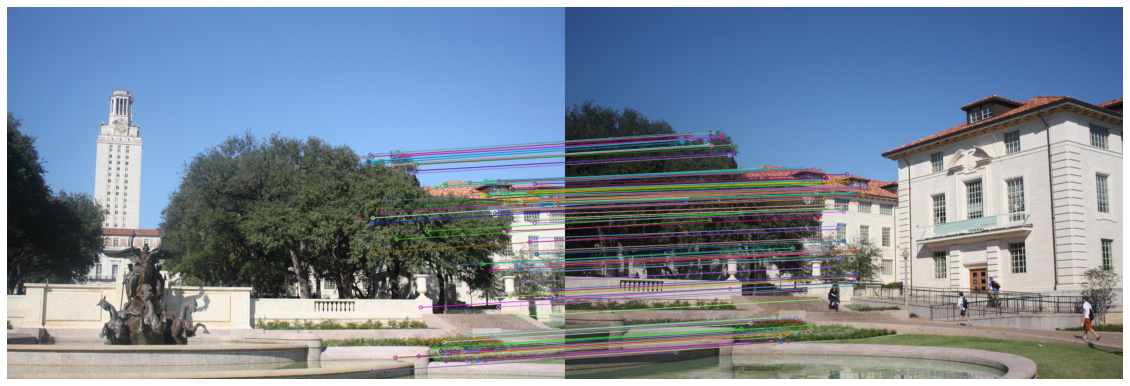

In [12]:
plot_inliners(left_rgb, inliners[:,:2], right_rgb, inliners[:, 2:4], inliners)


In [13]:
def warp_to_l(image, homograph):
    x, y, z = image.shape    
    vertices = [[0, 0], [y, 0], [y, x], [0, x]]
    vertices_new = []
    for vertice in vertices:
        vertice = np.append(np.array(vertice), 1)
        vertices_new.append(np.matmul(homograph, vertice))
    vertices_new = np.array(vertices_new).T

    new_x = vertices_new[0] / vertices_new[2]
    new_y = vertices_new[1] / vertices_new[2]
    min_y = min(new_y)
    min_x = min(new_x)
    max_y = max(new_y)
    max_x = max(new_x)
    translation_mat = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    homograph = np.dot(translation_mat, homograph)
    x_new = int(round(abs(min_y) + x))
    y_new = int(round(abs(min_x) + y))
    size = (y_new, x_new)
    warped_img = cv.warpPerspective(src=image, M=homograph, dsize=size)
    return warped_img, (min_x, min_y)

In [14]:
def move_to_r(image, move):
    p = move[0]
    q = move[1]
    new_move = np.array([[1, 0, -p], [0, 1, -q], [0, 0, 1]])
    x, y, z = image.shape
    x_new = int(round(abs(q) + x))
    y_new = int(round(abs(p) + y))
    s = (y_new, x_new)
    moved_img = cv.warpPerspective(src=image, M=new_move, dsize=s)
    return moved_img

In [15]:
def sew_image(left_image, right_image, homograph):
    action_l, move = warp_to_l(left_image, homograph)
    action_r = move_to_r(right_image, move)
  
    arr = np.zeros(3)
    for i in range(action_r.shape[0]):
        for j in range(action_r.shape[1]):
            l = action_l[i, j, :]
            r = action_r[i, j, :]
        
            if not np.array_equal(l, arr) and np.array_equal(r, arr):
                action_l[i, j, :] = l
            elif np.array_equal(l, arr) and not np.array_equal(r, arr):
                action_l[i, j, :] = r
            elif not np.array_equal(l, arr) and not np.array_equal(r, arr):
                action_l[i, j, :] = (l + r) / 2
            else:
                pass
    return action_l[:action_r.shape[0], :action_r.shape[1], :]

In [16]:
def plot_save_stitch(stitched, path):
    fig, ax = plt.subplots(figsize=(20, 11))
    ax.imshow(stitched)
    ax.axis('off')
    plt.show()

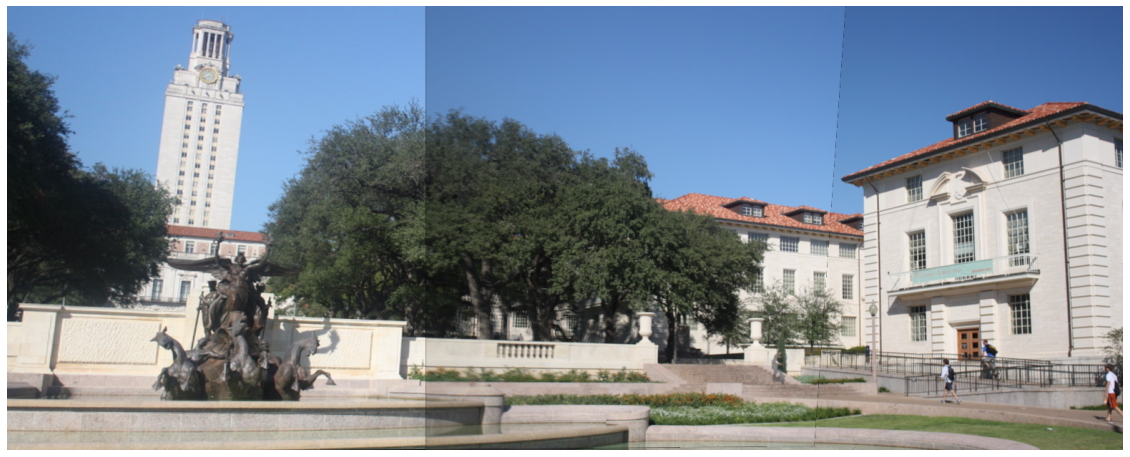

In [17]:
image_color_left = cv.imread('./left1.jpg')
image_color_left  = cv.normalize(image_color_left.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)   
image_color_right = cv.imread('./right1.jpg')
image_color_right  = cv.normalize(image_color_right.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)   
sewed = sew_image(image_color_left, image_color_right, H)
sewed = sewed[200:820, 40:1600]
figure, axis = plt.subplots(figsize=(20,11))
axis.imshow(sewed[:,:,::-1])
axis.axis('off')
plt.show()